# Predicción de Mercados usando Tensorflow

### Import de librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from datetime import datetime

2023-04-10 17:57:17.334394: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-10 17:57:17.430942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 17:57:17.834943: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 17:57:17.837862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 17:57:19.131001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Import de los datos

In [3]:
data = pd.read_csv('./stocks/TSLA_5yr.csv')
print(data.shape)
print(data.sample(7))

data['Date'] = pd.to_datetime(data['Date'])

(1258, 7)
           Date        Open        High         Low       Close   Adj Close  \
10   2018-04-24   19.000000   19.139334   18.563999   18.897333   18.897333   
889  2021-10-19  292.510010  292.649994  287.503326  288.089996  288.089996   
925  2021-12-09  353.546661  354.163330  334.119995  334.600006  334.600006   
931  2021-12-17  304.923340  320.220001  303.013336  310.856659  310.856659   
49   2018-06-19   24.344000   24.666668   23.083332   23.503332   23.503332   
227  2019-03-06   18.431999   18.767332   18.292667   18.416000   18.416000   
933  2021-12-21  305.623322  313.166656  295.373322  312.843323  312.843323   

        Volume  
10    85279500  
889   52143300  
925   59438400  
931  100437300  
49   191428500  
227  155032500  
933   71517900  


### Mostramos las velas diarias

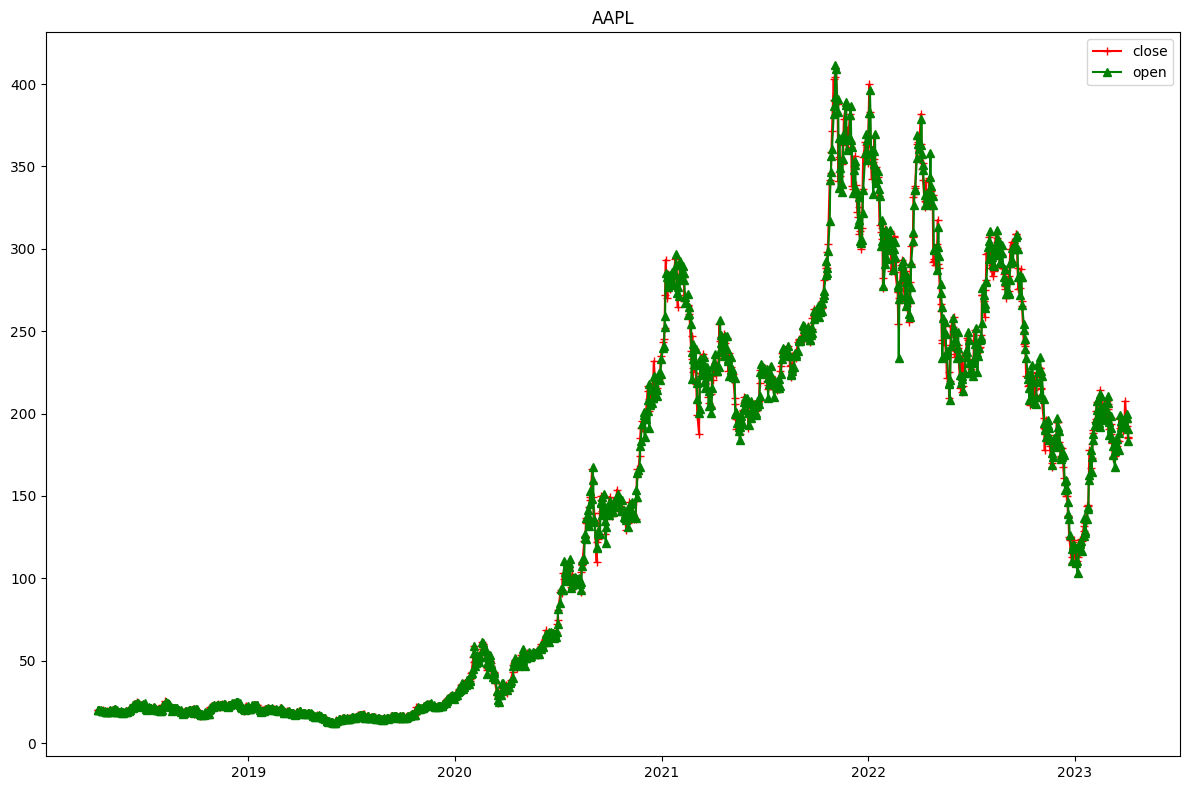

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()

### Mostramos el volumen diario

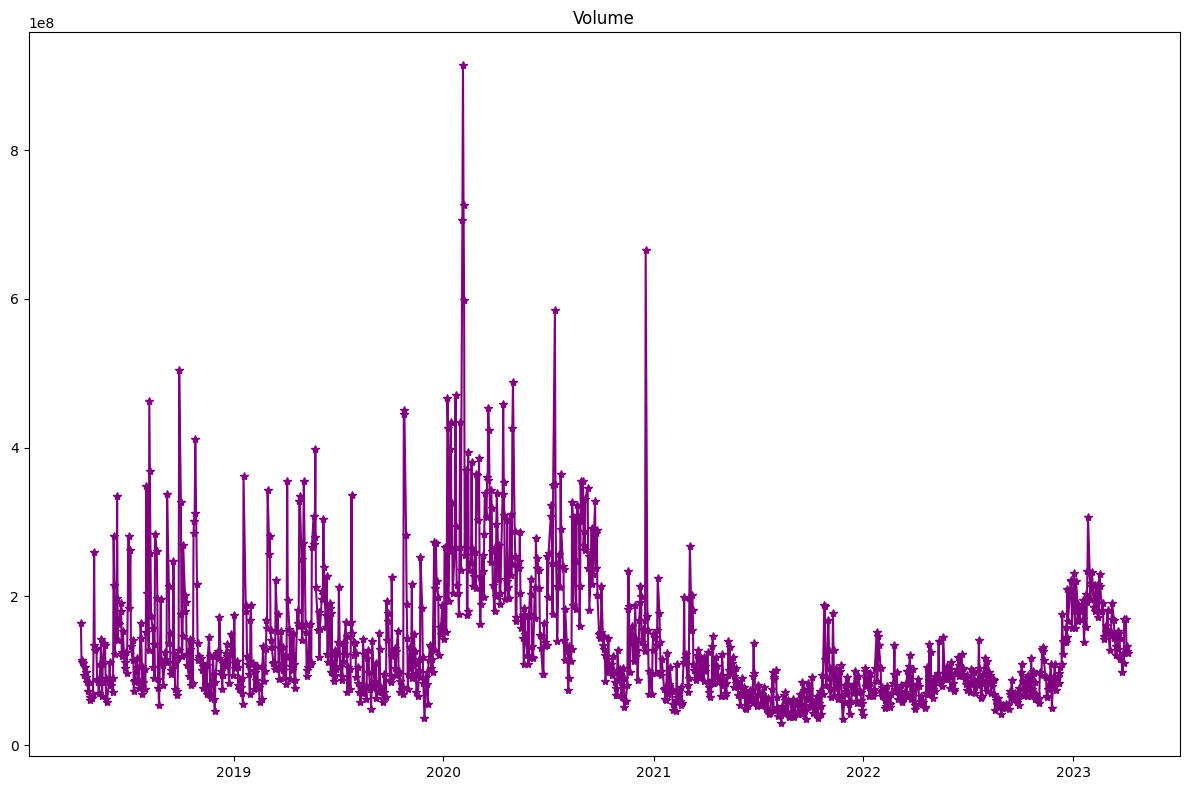

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

### Mostramos los datos de entreno

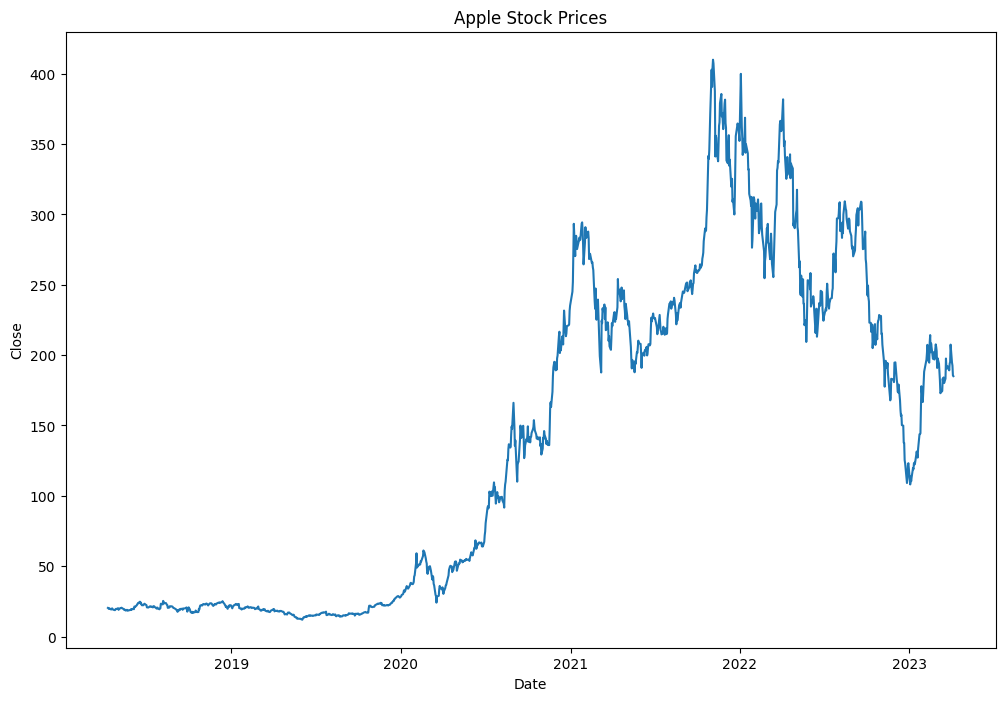

In [6]:
prediction_range = data.loc[(data['Date'] > datetime(2018,3,27)) & (data['Date'] < datetime(2023,3,27))]
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

### Establecemos el set de entrenamiento y otro para la validación (95%/5%)

In [7]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
testing = int(np.floor(len(dataset) * .05))
print(training)
print(testing)

1196
62


### Preparamos los datos para el entrenamiento

In [8]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]

x_train = []
y_train = []
  
for i in range(testing, len(train_data)):
    x_train.append(train_data[i - testing:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Preparamos el modelo

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

2023-04-10 17:57:22.353671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 17:57:22.355424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 17:57:22.356494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 62, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


### Procedemos a entrenar el modelo

In [10]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    verbose=1)

Epoch 1/10


2023-04-10 17:57:22.856508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 17:57:22.857422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 17:57:22.859402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 3s 33ms/step - loss: 0.0327
Epoch 2/10
36/36 [==============================] - 1s 32ms/step - loss: 0.0103
Epoch 3/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0085
Epoch 4/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0071
Epoch 5/10
36/36 [==============================] - 1s 34ms/step - loss: 0.0081
Epoch 6/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0069
Epoch 7/10
36/36 [==============================] - 1s 34ms/step - loss: 0.0071
Epoch 8/10
36/36 [==============================] - 1s 34ms/step - loss: 0.0070
Epoch 9/10
36/36 [==============================] - 1s 33ms/step - loss: 0.0062
Epoch 10/10
36/36 [==============================] - 1s 34ms/step - loss: 0.0064


### Establecemos los datos de prueba, generamos la predicción y los MSE

In [11]:
test_data = scaled_data[training - testing:, :]

x_test = []
y_test = dataset[training:, :]
for i in range(testing, len(test_data)):
    x_test.append(test_data[i-testing:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# prediccion de los datos de prueba
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# metricas MSE (Error Cuadrático Medio) y RMSE (Raiz del Error Cuadrático Medio)
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-04-10 17:57:37.221853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 17:57:37.223244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 17:57:37.224169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 15ms/step
MSE 474.7654247261803
RMSE 21.789112527273346


### Mostramos el resultado final con la predicción, entrenamiento y pruebas

/tmp/ipykernel_449/1080195945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


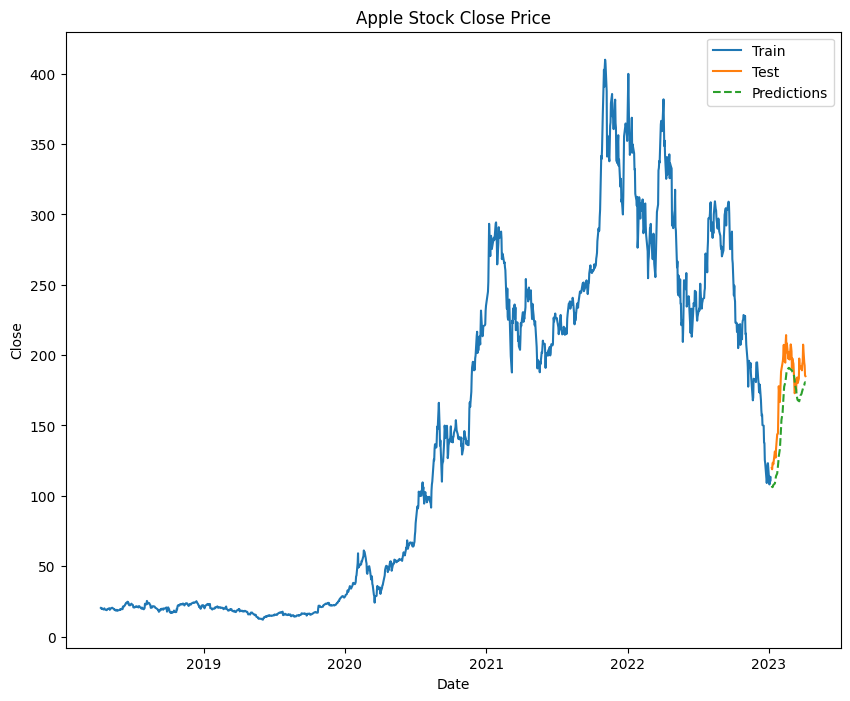

In [12]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test['Close'])
plt.plot(test['Date'], test['Predictions'], linestyle='dashed')
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([2022,2023,120,180])